

```
Target:
        1) Squeze the model (params<10k)
        2) try to get accuracy as good as possible.
        3) Can go up to 20 epochs and see if the accuracy above 99.
Result:
        1) Best Training Accuracy: 99.22
        2) Best Test Accuracy: 99.15
        3) Params: 9.8k
Analysis:
        1) Model is squezed ,accuracy dropped so now i should target to get more accuracy.
        2) Will add BatchNorm to increase Efficiency.
```



In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.convolution1 = nn.Sequential(
        nn.Conv2d(1, 10, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(10, 20, 3, padding=1),
        nn.ReLU(),
        #nn.BatchNorm2d(20),
        nn.MaxPool2d(2,2)
    )
    self.convolution2 = nn.Sequential(
        nn.Conv2d(20, 16, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 12, 3, padding=1),
        nn.ReLU(),
        #nn.BatchNorm2d(12),
        nn.MaxPool2d(2,2)
    )
    self.convolution3 = nn.Sequential(
        nn.Conv2d(12, 12, 3),
        nn.Conv2d(12, 10, 3),
        nn.Conv2d(10, 10, 3)
        # nn.ReLU(),
        # nn.Conv2d(16, 10, 3),
    )
  def forward(self, x):
    x = self.convolution1(x)
    x = self.convolution2(x)
    x = self.convolution3(x)
    x = x.view(-1,10)
    return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 20, 28, 28]           1,820
              ReLU-4           [-1, 20, 28, 28]               0
         MaxPool2d-5           [-1, 20, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           2,896
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 12, 14, 14]           1,740
              ReLU-9           [-1, 12, 14, 14]               0
        MaxPool2d-10             [-1, 12, 7, 7]               0
           Conv2d-11             [-1, 12, 5, 5]           1,308
           Conv2d-12             [-1, 10, 3, 3]           1,090
           Conv2d-13             [-1, 10, 1, 1]             910
Total params: 9,864
Trainable params: 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.manual_seed(1)
batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST("../data", train=True, download=True,
                               transform = transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                               ])),
                batch_size=batch_size, shuffle=True, **kwargs
              )
test_loader = torch.utils.data.DataLoader(
              datasets.MNIST("../data", train=False, download=True,
                             transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,),(0.3081,))
                             ])),
              batch_size=batch_size, shuffle=True, **kwargs
              )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [5]:
import os
print(os.listdir("sample_data"))

['README.md', 'anscombe.json', 'mnist_test.csv', 'california_housing_train.csv', 'california_housing_test.csv', 'mnist_train_small.csv']


Text(0.5, 1.0, '4')

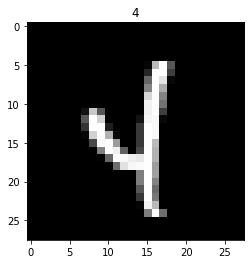

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
df_train = pd.read_csv('sample_data/mnist_train_small.csv')
import matplotlib.pyplot as plt
ind = np.random.randint(0, df_train.shape[0]-1)
plt.imshow(df_train.iloc[ind].values[1:].reshape((28,28)), cmap='gray')
plt.title(str(df_train.iloc[ind][0]))

In [7]:
from tqdm import tqdm
train_loss = []
train_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    correct=0
    processed=0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(0, 20):
  print (f"epoch : {epoch}")
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

epoch : 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.16366265714168549 batch_id=468 Accuracy=73.73333333333333: 100%|██████████| 469/469 [00:37<00:00, 12.60it/s]



Test set: Average loss: 0.0941, Accuracy: 9712/10000 (97%)

epoch : 1


loss=0.029210271313786507 batch_id=468 Accuracy=96.805: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]



Test set: Average loss: 0.0676, Accuracy: 9783/10000 (98%)

epoch : 2


loss=0.1774769425392151 batch_id=468 Accuracy=97.67833333333333: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]



Test set: Average loss: 0.0627, Accuracy: 9803/10000 (98%)

epoch : 3


loss=0.09374021738767624 batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:22<00:00, 20.59it/s]



Test set: Average loss: 0.0487, Accuracy: 9829/10000 (98%)

epoch : 4


loss=0.01632358692586422 batch_id=468 Accuracy=98.415: 100%|██████████| 469/469 [00:24<00:00, 19.15it/s]



Test set: Average loss: 0.0387, Accuracy: 9872/10000 (99%)

epoch : 5


loss=0.14017443358898163 batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]



Test set: Average loss: 0.0419, Accuracy: 9869/10000 (99%)

epoch : 6


loss=0.02826506644487381 batch_id=468 Accuracy=98.70333333333333: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]



Test set: Average loss: 0.0322, Accuracy: 9899/10000 (99%)

epoch : 7


loss=0.05212726071476936 batch_id=468 Accuracy=98.785: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]



Test set: Average loss: 0.0359, Accuracy: 9884/10000 (99%)

epoch : 8


loss=0.006099140737205744 batch_id=468 Accuracy=98.89166666666667: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0284, Accuracy: 9904/10000 (99%)

epoch : 9


loss=0.007616488728672266 batch_id=468 Accuracy=98.98166666666667: 100%|██████████| 469/469 [00:22<00:00, 20.77it/s]



Test set: Average loss: 0.0306, Accuracy: 9894/10000 (99%)

epoch : 10


loss=0.01735667884349823 batch_id=468 Accuracy=99.01166666666667: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]



Test set: Average loss: 0.0333, Accuracy: 9890/10000 (99%)

epoch : 11


loss=0.0009391130297444761 batch_id=468 Accuracy=99.09166666666667: 100%|██████████| 469/469 [00:22<00:00, 20.49it/s]



Test set: Average loss: 0.0338, Accuracy: 9889/10000 (99%)

epoch : 12


loss=0.02291213907301426 batch_id=468 Accuracy=99.14166666666667: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0264, Accuracy: 9914/10000 (99%)

epoch : 13


loss=0.03390604630112648 batch_id=468 Accuracy=99.10166666666667: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0272, Accuracy: 9915/10000 (99%)

epoch : 14


loss=0.006059879902750254 batch_id=468 Accuracy=99.22166666666666: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0344, Accuracy: 9888/10000 (99%)

epoch : 15


loss=0.004578915424644947 batch_id=468 Accuracy=99.30166666666666: 100%|██████████| 469/469 [00:23<00:00, 20.10it/s]



Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99%)

epoch : 16


loss=0.003452991135418415 batch_id=468 Accuracy=99.28666666666666: 100%|██████████| 469/469 [00:22<00:00, 20.71it/s]



Test set: Average loss: 0.0259, Accuracy: 9915/10000 (99%)

epoch : 17


loss=0.009682760573923588 batch_id=468 Accuracy=99.34333333333333: 100%|██████████| 469/469 [00:22<00:00, 20.78it/s]



Test set: Average loss: 0.0286, Accuracy: 9898/10000 (99%)

epoch : 18


loss=0.024093588814139366 batch_id=468 Accuracy=99.38333333333334: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0329, Accuracy: 9895/10000 (99%)

epoch : 19


loss=0.005955208092927933 batch_id=468 Accuracy=99.40333333333334: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]



Test set: Average loss: 0.0351, Accuracy: 9893/10000 (99%)

